*Unit 2, Sprint 3, Module 2*

---


# Wrangle ML datasets 
- Explore tabular data for supervised machine learning
- Join relational data for supervised machine learning

# Explore tabular data for superviesd machine learning 🍌

Wrangling your dataset is often the most challenging and time-consuming part of the modeling process.

In today's lesson, we’ll work with a dataset of [3 Million Instacart Orders, Open Sourced](https://tech.instacart.com/3-million-instacart-orders-open-sourced-d40d29ead6f2)!

Let’s get set up:

In [16]:
# Download data
import requests

def download(url):
    filename = url.split('/')[-1]
    print(f'Downloading {url}')
    r = requests.get(url)
    print("type(r):\n", type(r))
    with open(filename, 'wb') as f:
        f.write(r.content)
    print(f'Downloaded {filename}')
# The file is 190MB and can't be uploaded on github
download(url = 'https://nicks-datasets.s3-us-west-2.amazonaws.com/instacart_online_grocery_shopping_2017_05_01.tar.gz'
)

type(r):
 <class 'requests.models.Response'>
Downloaded instacart_online_grocery_shopping_2017_05_01.tar.gz


In [17]:
ls

README.md
instacart_online_grocery_shopping_2017_05_01.tar.gz
skhabiri_LS_DS_232_assignment.ipynb
skhabiri_LS_DS_build2_assignment.ipynb
wranglemldatasets-232.ipynb


In [18]:
# Uncompress data
import tarfile
tar = tarfile.open('instacart_online_grocery_shopping_2017_05_01.tar.gz')
tar.extractall()
tar.close()

In [20]:
%pwd

'/Users/shahnam/ds/repos/PredictiveModeling-AppliedModeling-u2s3/WrangleMLDatasets-m2'

In [21]:
# Change directory to where the data was uncompressed
%cd instacart_2017_05_01

/Users/shahnam/ds/repos/PredictiveModeling-AppliedModeling-u2s3/WrangleMLDatasets-m2/instacart_2017_05_01


In [23]:
# Print the csv filenames
'''
The glob module finds all the pathnames matching a specified pattern 
according to the rules used by the Unix shell, *, ?, ...
'''
from glob import glob
for filename in glob('*.csv'):
    print(filename)

products.csv
orders.csv
order_products__train.csv
departments.csv
aisles.csv
order_products__prior.csv


In [27]:
# For each csv file, look at its shape & head
import pandas as pd
from IPython.display import display


def preview():
  for filename in glob('*.csv'):
    df = pd.read_csv(filename)
    print ('\n',filename, df.shape)
    display(df.head())

preview()


 products.csv (49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13



 orders.csv (3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0



 order_products__train.csv (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1



 departments.csv (21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol



 aisles.csv (134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation



 order_products__prior.csv (32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


### The original task was complex ...

[The Kaggle competition said,](https://www.kaggle.com/c/instacart-market-basket-analysis/data):

> The dataset for this competition is a relational set of files describing customers' orders over time. The goal of the competition is to predict which products will be in a user's next order.

> orders.csv: This file tells to which set (prior, train, test) an order belongs. You are predicting reordered items only for the test set orders.

Each row in the submission is an order_id from the test set, followed by product_id(s) predicted to be reordered.

> sample_submission.csv: 
```
order_id,products
17,39276 29259
34,39276 29259
137,39276 29259
182,39276 29259
257,39276 29259
```

### ... but we can simplify!

Simplify the question, from "Which products will be reordered?" (Multi-class, [multi-label](https://en.wikipedia.org/wiki/Multi-label_classification) classification) to **"Will customers reorder this one product?"** (Binary classification)

Which product? How about **the most frequently ordered product?**

### Questions:

- What is the most frequently ordered product?
- How often is this product included in a customer's next order?
- Which customers have ordered this product before?
- How can we get a subset of data, just for these customers?
- What features can we engineer? We want to predict, will these customers reorder this product on their next order?

## Follow Along

### What was the most frequently ordered product?

In [28]:
order_products__train = pd.read_csv('order_products__train.csv')
order_products__train['product_id'].value_counts()

24852    18726
13176    15480
21137    10894
21903     9784
47626     8135
         ...  
44256        1
2764         1
4815         1
43736        1
46835        1
Name: product_id, Length: 39123, dtype: int64

In [37]:
# sort by putting the lowest product id number at the top
temp = order_products__train.sort_values(by='product_id', ascending=True).head(10)
print(temp.shape, order_products__train.shape)
temp

(10, 4) (1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
666335,1639546,1,10,1
1188548,2936483,1,9,1
855368,2111236,1,3,1
771078,1897200,1,24,1
1109911,2742935,1,2,1
1232335,3044039,1,3,0
507205,1245784,1,7,0
445796,1091681,1,15,1
122023,298510,1,1,1
1062956,2628526,1,1,0


In [38]:
products = pd.read_csv("products.csv")
print(products.shape)
products.head()

(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [42]:
products["product_id"].value_counts(ascending=False)

2047     1
44351    1
48477    1
46428    1
36187    1
        ..
19100    1
29339    1
31386    1
25241    1
2049     1
Name: product_id, Length: 49688, dtype: int64

In [39]:
train = pd.merge(order_products__train, products, how='inner', left_on='product_id', right_on='product_id')
train['product_name'].value_counts()

Banana                                                       18726
Bag of Organic Bananas                                       15480
Organic Strawberries                                         10894
Organic Baby Spinach                                          9784
Large Lemon                                                   8135
                                                             ...  
Swiss Cheese Deli Slices                                         1
Sin Zin                                                          1
Calming Hair Conditioner                                         1
Men's Rogaine Hair Regrowth Treatment Foam 3-Month Supply        1
Ultra Max Fresh Solid Antiperspirant Deodorant                   1
Name: product_name, Length: 39123, dtype: int64

### How often are bananas included in a customer's next order?

There are [three sets of data](https://gist.github.com/jeremystan/c3b39d947d9b88b3ccff3147dbcf6c6b):

> "prior": orders prior to that users most recent order (3.2m orders)  
"train": training data supplied to participants (131k orders)  
"test": test data reserved for machine learning competitions (75k orders)

Customers' next orders are in the "train" and "test" sets. (The "prior" set has the orders prior to the most recent orders.)

We can't use the "test" set here, because we don't have its labels (only Kaggle & Instacart have them), so we don't know what products were bought in the "test" set orders.

So, we'll use the "train" set. It currently has one row per product_id and multiple rows per order_id.

But we don't want that. Instead we want one row per order_id, with a binary column: "Did the order include bananas?"

Let's wrangle!

In [54]:
train.sample(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
92336,763776,45007,2,0,Organic Zucchini,83,4,False
623672,361165,4605,1,1,Yellow Onions,83,4,False
1194189,3092479,43210,13,1,Rolled Oats,68,10,False
1144949,591571,28987,3,1,Vanilla Bottles,92,18,False
1209425,904566,21115,6,1,Oikos Greek Vanilla Yogurt,120,16,False
846985,3378143,46175,5,0,Half Baked® Ice Cream,37,1,False
110438,3163795,43772,3,0,Cherubs Heavenly Salad Tomatoes,83,4,False
793784,113986,19887,4,1,Unsweetened Vanilla Almond Breeze,91,16,False
690372,2396437,14233,1,1,Natural Artesian Water,115,7,False
282234,1421193,3798,5,1,Pink Lady Apples,24,4,False


In [55]:
train['bananas'] = train['product_name'] == 'Banana'

# Of banana orders, how many are re-orders?
bananas = train[train['bananas']]   # a subset of train with banana as product
bananas['reordered'].value_counts(normalize=True)

1    0.884172
0    0.115828
Name: reordered, dtype: float64

In [56]:
bananas.shape, train.shape

((18726, 8), (1384617, 8))

*One order id with multiple products are on multiple rows*

In [67]:
train[train["order_id"]==3092479]

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
72920,3092479,40396,7,1,Guacamole,67,20,False
146579,3092479,24852,3,0,Banana,24,4,True
213627,3092479,21903,5,0,Organic Baby Spinach,123,4,False
259776,3092479,15261,10,1,Organic Rosemary,16,4,False
262590,3092479,18465,20,1,Organic Grade A Free Range Large Brown Eggs,86,16,False
310698,3092479,8670,2,0,Diced Tomatoes,81,15,False
354497,3092479,8490,18,0,Strawberry Rhubarb Yogurt,120,16,False
410317,3092479,37107,21,0,Ground Cumin,104,13,False
447019,3092479,40516,6,0,Organic Romaine Hearts,123,4,False
475904,3092479,44683,9,1,Brussels Sprouts,83,4,False


In [57]:
# How often is this product (i.e., bananas) included in the customer's next order?
train['bananas'].value_counts(normalize=True)

False    0.986476
True     0.013524
Name: bananas, dtype: float64

This is not necessarily correct as one order is in multiple rows for each producct in that order. So we need to consolidate the row based on orders first.

In [65]:
train.groupby(by=['order_id']).sum()

,product_id,add_to_cart_order,reordered,aisle_id,department_id,bananas
order_id,,,,,,
1,246393,36,4,558,79,0
36,328368,36,6,641,87,0
38,223364,45,1,629,57,0
96,209011,28,5,780,38,0
98,1367995,1225,45,3298,597,0
...,...,...,...,...,...,...
3421049,170272,21,1,502,34,0
3421056,65706,15,3,388,40,0
3421058,166088,36,7,404,100,0


In [71]:
(train.groupby(by=['order_id']).sum())['bananas'].value_counts(normalize=True)

0    0.857281
1    0.142719
Name: bananas, dtype: float64

14% of the next orders have banana. Aletrnative way to do this:

In [75]:
train.groupby('order_id')['bananas']

In [76]:
# How often is this product (i.e., bananas) included in the customer's next order?

train_wrangled = train.groupby('order_id')['bananas'].any().reset_index()
train_wrangled

,order_id,bananas
0,1,False
1,36,False
2,38,False
3,96,False
4,98,False
...,...,...
131204,3421049,False
131205,3421056,False
131206,3421058,False
131207,3421063,False


In [77]:
train_wrangled['bananas'].value_counts(normalize=True)

False    0.857281
True     0.142719
Name: bananas, dtype: float64

In [80]:
ls

aisles.csv                 order_products__train.csv
departments.csv            orders.csv
order_products__prior.csv  products.csv


In [87]:
orders = pd.read_csv("orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [89]:
orders["order_number"].describe()

count    3.421083e+06
mean     1.715486e+01
std      1.773316e+01
min      1.000000e+00
25%      5.000000e+00
50%      1.100000e+01
75%      2.300000e+01
max      1.000000e+02
Name: order_number, dtype: float64

In [90]:
#repeated orders
orders = orders.loc[orders['days_since_prior_order'] != 0]
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [94]:
train2 = pd.merge(train, orders, how='inner', left_on='order_id', right_on='order_id')
train2.shape, train.shape

((1367573, 14), (1384617, 8))

In [97]:
# What is the most common hour of the day for any food orders?
train2['order_hour_of_day'].value_counts(normalize=True)

14    0.086165
15    0.083653
13    0.082967
11    0.082637
12    0.080978
10    0.080265
16    0.079634
17    0.069734
9     0.067969
18    0.054985
8     0.049023
19    0.041715
20    0.029383
7     0.026361
21    0.024919
22    0.019583
23    0.012143
6     0.008604
0     0.006611
1     0.004059
5     0.002761
2     0.002344
4     0.001766
3     0.001743
Name: order_hour_of_day, dtype: float64

In [96]:
# What is the most common hour of the day that bananas are ordered?

import numpy as np

train2[train2['bananas']]['order_hour_of_day'].value_counts(normalize=True)

14    0.083675
15    0.081192
10    0.080544
11    0.078493
16    0.078385
12    0.078277
13    0.077467
9     0.073202
17    0.070125
18    0.061110
8     0.055010
19    0.043997
20    0.029421
7     0.028666
21    0.024131
22    0.019218
23    0.011337
6     0.008799
0     0.005398
1     0.003671
5     0.002753
2     0.002483
4     0.001458
3     0.001188
Name: order_hour_of_day, dtype: float64

# Join relational data for supervised machine learning

## Overview
Often, you’ll need to join data from multiple relational tables before you’re ready to fit your models.

### Which customers have ordered this product before?

- Customers are identified by `user_id`
- Products are identified by `product_id`

Do we have a table with both these id's?

(If not, how can we combine this information?)

No, we don't have a table with both these id's. But:

orders.csv has user_id and order_id
order_products__prior.csv has order_id and product_id
order_products__train.csv has order_id and product_id too

In [98]:
banana_order_ids = train[train.bananas==True].order_id

In [99]:
orders = pd.read_csv("orders.csv")
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [100]:
orders[orders.order_id.isin(banana_order_ids)]

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
25,1492625,2,train,15,1,11,30.0
485,698604,34,train,6,4,13,30.0
623,1864787,43,train,12,5,11,26.0
652,1947848,46,train,20,4,20,11.0
881,13318,56,train,13,1,9,6.0
...,...,...,...,...,...,...,...
3420581,681092,206181,train,15,1,13,30.0
3420692,2530125,206191,train,6,0,9,30.0
3420786,3383615,206196,train,5,0,15,30.0
3420933,1716008,206205,train,4,1,16,10.0


In [142]:
# Which unique user_ids bought bananas?
orders[orders.order_id.isin(banana_order_ids)]['user_id']

25              2
485            34
623            43
652            46
881            56
            ...  
3420581    206181
3420692    206191
3420786    206196
3420933    206205
3421082    206209
Name: user_id, Length: 18726, dtype: int64

## Follow Along

### How can we get a subset of data, just for these customers?

We want *all* the orders from customers who have *ever* bought bananas.

(And *none* of the orders from customers who have *never* bought bananas.)

### What features can we engineer? We want to predict, will these customers reorder bananas on their next order?

- Products per order
- Time of day
- Have they reordered bananas before? (Have ordered bananas >= 2 times)
- Other fruit they buy
- Size of orders (customers with smaller orders on average are less likely to be reordering any particular product on their next order)
- Frequency of banana orders:
    - % of orders
    - Time between banana orders: Every n days on average
    - Raw count: Total orders, how many times have you ordered bananas?
- Recency of banana orders
    - n days since you ordered banana

In [ ]:
# Is there a difference in average order size in banana-containing orders vs. all orders?

In [107]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [108]:
banana_order_ids

129688        226
129689        473
129690        878
129691       1042
129692       1139
           ...   
148409    3419531
148410    3419542
148411    3419629
148412    3420088
148413    3420996
Name: order_id, Length: 18726, dtype: int64

In [109]:
train.groupby(['order_id']).count()

,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,bananas
order_id,,,,,,,
1,8,8,8,8,8,8,8
36,8,8,8,8,8,8,8
38,9,9,9,9,9,9,9
96,7,7,7,7,7,7,7
98,49,49,49,49,49,49,49
...,...,...,...,...,...,...,...
3421049,6,6,6,6,6,6,6
3421056,5,5,5,5,5,5,5
3421058,8,8,8,8,8,8,8


In [110]:
"""
Group by order_id, counts unique product (one unique per row in train dataframe), 
and prints out count of unique rows (products) per order
"""
product_order_counts = train.groupby(['order_id']).count()['product_id']
product_order_counts.mean()

10.552759338155157

/Users/shahnam/.pyenv/versions/3.7.8/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='product_id', ylabel='Density'>

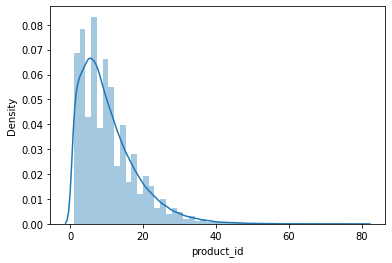

In [111]:
import seaborn as sns
sns.distplot(product_order_counts)

In [112]:
banana_order_counts = train[train.order_id.isin(banana_order_ids)].groupby(['order_id']).count()['product_id']
banana_order_counts.mean()

14.977517889565311

## Challenge

**Continue to clean and explore your data.** Can you **engineer features** to help predict your target? For the evaluation metric you chose, what score would you get just by guessing? Can you **make a fast, first model** that beats guessing?

We recommend that you use your portfolio project dataset for all assignments this sprint. But if you aren't ready yet, or you want more practice, then use the New York City property sales dataset today. Follow the instructions in the assignment notebook. [Here's a video walkthrough](https://youtu.be/pPWFw8UtBVg?t=584) you can refer to if you get stuck or want hints!